In [1]:
import torch
from torch import nn
import torch.nn.functional as F

from data.data import *
from utils import *
from params import *

import math

SEQUENCE_LENGTH = 400
U_ITEMS = int(SEQUENCE_LENGTH / 25)


# Design

## Decoder

mmeory: B x L_c x D_model
tgt: B x L_s x 3

Decoding step: 
1. Linear layer to convert tgt to B x L_s x D_model
2. Perform convolution; each convolution kernel move along L_s
3. Attention over these convolution kernel
    1. in self attention, query is the tgt, key is the convoluted tgt and the value the convoluted tgt


# Implementation

## Data

In [2]:
data_loader = DataReader('data/processed')
data_gen = data_loader.train_batch_generator(3)
batch = None
for b in data_gen:
    batch = b
    break
    
x = batch['x']
x_len = batch['x_len']
y = batch['y']
c = batch['c']
c_len = batch['c_len']

assert((x[:, 1:, :] == y[:, :-1, :]).all())

print("x.shape", x.shape)
print("x_len.shape", x_len.shape)
print("y.shape", y.shape)
print("c.shape", c.shape)

train size 11034
val size 581
test size 11615
x.shape torch.Size([3, 608, 2])
x_len.shape torch.Size([3])
y.shape torch.Size([3, 608, 2])
c.shape torch.Size([3, 31])


torch.int64


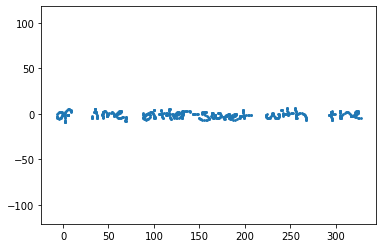

In [3]:
# print("source string", num_to_string(c.squeeze().tolist()))
print(c.dtype)
draw(x[2, :, :], None)

In [4]:
class Debugger:
    def __init__(self, function_name, debug=True):
        self.function_name = function_name
        self.debug = debug
    
    def print(self, *argv):
        if self.debug:
            print("[{}]".format(self.function_name), argv, sep=" ")


## Convolution 

tgt: B x L x 3
we can view 3 as the input channel size. 

tgt: B x L x D_model 

In [5]:
def clones(module, N):
    """Produce N identical layers."""
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [6]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self):
        super(PositionalEncoding, self).__init__()
        max_len = max(MAX_CHAR_LEN, MAX_STROKE_LEN)
        self.dropout = nn.Dropout(p=TF_DROPOUT)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, TF_D_MODEL, requires_grad=False)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, TF_D_MODEL, 2) *
                             -(math.log(10000.0) / TF_D_MODEL))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        with torch.no_grad():
            x = x + self.pe[:, :x.size(1)]
            return self.dropout(x)

class TFHW_Convolution(nn.Module):
    def __init__(self, d_model = TF_D_MODEL, d_stroke = D_STROKE, num_heads = TF_N_HEADS,
                    dim_feedforward=TF_DIM_FEEDFORWARD,
                 out_channels = OUT_CHANNELS, kernel_size = KERNEL_SIZE, stride = STRIDE, padding=KERNEL_SIZE,
                 alphabet_size = ALPHABET_SIZE, max_stroke_len = MAX_STROKE_LEN, debug=False) -> None:
        super(TFHW_Convolution, self).__init__()


        self.alphabet_size = alphabet_size
        self.max_stroke_len = max_stroke_len

        self.d_model = d_model

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.encoder = nn.Sequential(nn.Embedding(alphabet_size, d_model), PositionalEncoding())

        self.tgt_embed = nn.Sequential(nn.Linear(d_stroke, d_model), PositionalEncoding())
        self.tgt_conv_embed = nn.Linear(out_channels, d_model)
        self.conv1d = nn.Conv1d(
            in_channels=d_stroke, out_channels=out_channels,
            kernel_size=kernel_size, stride=stride, padding = padding
        )
        self.conv_attention = nn.MultiheadAttention(
            embed_dim=d_model, num_heads=num_heads, batch_first=True
        )
        self.conv_attn_mask = self.convolution_attention_mask().to(DEVICE)
        # shape: MAX_SEQ_LEN x MAX_SEQ_LEN
        self.multi_head_attn = nn.MultiheadAttention(
            embed_dim=d_model, num_heads=num_heads, batch_first=True
        )

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.activation = F.relu

        self.generator = nn.Linear(d_model, d_stroke)

        self._reset_parameters()
        self.debugger = Debugger("TFHW_Convolution", debug)

    def encode(self, c):
        encoding = self.encoder(c)
        self.debugger.print("encoding shape", encoding.shape)

        return encoding

    def decode(self, tgt, mem, conv_tgt_mask, mem_mask, conv_tgt_padding_mask, mem_padding_mask):

        self.debugger.print("tgt shape", tgt.shape)

        tgt_embed = self.tgt_embed(tgt)

        # convolve
        # convolution requires in B x Cin x Lin
        tgt_conv_in = tgt.transpose(-1, -2)

        self.debugger.print("tgt_conv_in shape", tgt_conv_in.shape)
        tgt_conv_out = self.conv1d(tgt_conv_in).transpose(-1, -2) # B x L out x C out
        tgt_conv_embed = self.tgt_conv_embed(tgt_conv_out)

        self.debugger.print("tgt_conv_embed shape", tgt_conv_embed.shape)

#         post_kernel_tgt_embed = tgt_embed[:, self.kernel_size:, :]
        self.debugger.print("tgt_embed shape", tgt_embed.shape)

        # tranformer block

        self.debugger.print("tgt_conv_embed ", tgt_conv_embed)
        self.debugger.print("tgt_embed ", tgt_embed)
        self.debugger.print("new conv_tgt_mask shape ", conv_tgt_mask[self.kernel_size:, :])
        self.debugger.print("new conv_tgt_mask shape ", conv_tgt_mask[self.kernel_size:, :].shape)
#         self.debugger.print("post_kernel_tgt_embed shape", post_kernel_tgt_embed.shape)

        # self-attention with convolution
        x = tgt_embed + self.conv_attention(
            query = tgt_embed,
            key=tgt_conv_embed,
            value=tgt_conv_embed,
            key_padding_mask=conv_tgt_padding_mask,
            attn_mask=conv_tgt_mask,
            need_weights = False
        )[0]


        x = self.norm1(x)
        self.debugger.print("norm1 x ", )
        self.debugger.print("x shape", x.shape)
        self.debugger.print("mem type", mem.dtype)
        # multi-headed attention with mem
        x = x + self.multi_head_attn(
            query = x,
            key = mem,
            value = mem,
            attn_mask = mem_mask,
            key_padding_mask = mem_padding_mask,
            need_weights = False
        )[0]
        x = self.norm2(x)
        self.debugger.print("norm2 x ", )

        # linear layer
        x = self.linear2(self.activation(self.linear1(x)))
        x = self.norm3(x)

        # transformer block ends

        self.debugger.print("x ", )
        return self.generator(x)


    def forward(self, batch):
        x, c, x_len, c_len = batch['x'], batch['c'], batch['x_len'], batch['c_len']
        B, L, _ = x.shape

        mem = self.encode(c)

        conv_tgt_len = self.l_in_to_l_out(L, self.kernel_size, self.stride, self.padding)

        if conv_tgt_len > 0: # x is not long enough sequentially for a kernel
            conv_tgt_mask = self.conv_attn_mask[:L, :conv_tgt_len]
            conv_tgt_padding_mask = self.convolution_padding_mask(conv_tgt_len, x_len).to(DEVICE)
            self.debugger.print("conv_tgt_mask shape", conv_tgt_mask.shape)
            self.debugger.print("conv_tgt_padding_mask shape", conv_tgt_padding_mask.shape)
            self.debugger.print("conv_tgt_padding_mask pad count", torch.sum(conv_tgt_padding_mask, dim=1))
        else:
            conv_tgt_mask = None
            conv_tgt_padding_mask = None

        mem_padding_mask = create_pad_mask(c, c_len).to(DEVICE)

        self.debugger.print("tgt shape", x.shape)
        self.debugger.print("mem_padding_mask shape", mem_padding_mask.shape)

        decoding = self.decode(x, mem, conv_tgt_mask, None, conv_tgt_padding_mask, mem_padding_mask)
        return decoding

    def loss_fn(self, decode_strokes, batch):
        tgt_strokes = batch['y']

        mask = create_pad_mask(decode_strokes, batch['x_len']).to(DEVICE)

        coord_loss = F.mse_loss(tgt_strokes[..., :2], decode_strokes[..., :2], reduction="none")
        self.debugger.print("coord_loss ", coord_loss)
        coord_mask = mask.unsqueeze(-1).expand(coord_loss.shape)
        coord_loss = coord_loss.masked_fill_(coord_mask, 0)
        self.debugger.print("coord_loss ", coord_loss)
        coord_loss = torch.sum(coord_loss) / torch.sum(coord_mask == False)

        self.debugger.print("coord_loss shape", coord_loss.shape)

        return coord_loss

    def convolution_attention_mask(self):
        mask = create_pad_mask_by_len(
            self.l_in_to_l_out(self.max_stroke_len, self.kernel_size, self.stride, self.padding),
            torch.tensor([self.l_in_to_l_out(i, self.kernel_size, self.stride, self.padding) for i in range(self.max_stroke_len)])
        )

#         mask[:, 0] = False # so that multiheaded attention don't have nan
        return mask

    def convolution_padding_mask(self, conv_tgt_len, tgt_len):
        self.debugger.print(
            "len",
            conv_tgt_len
        )

        return create_pad_mask_by_len(
            conv_tgt_len,
            torch.tensor([self.l_in_to_l_out_ceil(l, self.kernel_size, self.stride, self.padding) for l in tgt_len])
        )

    def l_in_to_l_out(self, l_in, kernel_size, stride, padding, dilation=1):
        return math.floor(
            (l_in + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1
        )

    def l_in_to_l_out_ceil(self, l_in, kernel_size, stride, padding, dilation=1):
        return math.ceil(
            (l_in + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1
        )

    def _reset_parameters(self):
        r"""Initiate parameters in the transformer model."""

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)





In [7]:
def train_loop(model, optimizer, batch):
    optimizer.zero_grad()
    output = model(batch)
    loss = model.loss_fn(output, batch)
    loss.backward()
    optimizer.step()
    return loss

In [8]:
model = TFHW_Convolution(debug=False).to(DEVICE)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001, betas=(0.0, 0.999), weight_decay=0, eps=1e-8
)
train_losses = []
for epoch in range(EPOCHS):
#     train_data = data_reader.train_batch_generator(BATCH_SIZE)
#     val_data = data_reader.test_batch_generator(BATCH_SIZE)
    wandb_log = {}
    wandb_log["train_loss"] = 0

#     for batch in train_data:
    B, L, _ = batch['x'].shape
    loss = train_loop(model, optimizer, batch)
    wandb_log["train_loss"] += batch['x'].shape[0] * loss.item()
    print(wandb_log["train_loss"])
    train_losses.append(wandb_log['train_loss'])
    
    break

17.150676727294922


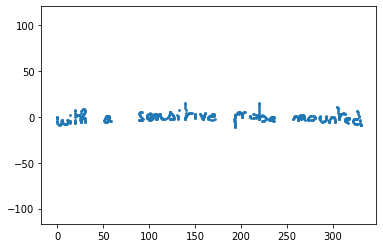

In [9]:
draw(batch["x"][0])

In [10]:
def predict_no_guidance(model, batch):
    """_summary_

    Args:
        batch_seq_char (N, L): sequence of character using the ALPHABET indexing
        batch_seq_char_len (N): lenght of each sequence in the batch
    """
    print("pred")
    tgt = torch.zeros(size=[1, 1, 2]).to(DEVICE)
    sequence_length = batch['c_len'].item() * 25

    with torch.no_grad():
        while tgt.shape[1] < sequence_length:
            batch['x'] = tgt
            batch['x_len'] = np.asarray([tgt.shape[1]])
            out = model(batch)
            tgt = torch.cat([tgt, out[:, [-1], :]], 1)
            print(out.shape, tgt.shape)

    return tgt


pred
torch.Size([1, 1, 2]) torch.Size([1, 2, 2])
torch.Size([1, 2, 2]) torch.Size([1, 3, 2])
torch.Size([1, 3, 2]) torch.Size([1, 4, 2])
torch.Size([1, 4, 2]) torch.Size([1, 5, 2])
torch.Size([1, 5, 2]) torch.Size([1, 6, 2])
torch.Size([1, 6, 2]) torch.Size([1, 7, 2])
torch.Size([1, 7, 2]) torch.Size([1, 8, 2])
torch.Size([1, 8, 2]) torch.Size([1, 9, 2])
torch.Size([1, 9, 2]) torch.Size([1, 10, 2])
torch.Size([1, 10, 2]) torch.Size([1, 11, 2])
torch.Size([1, 11, 2]) torch.Size([1, 12, 2])
torch.Size([1, 12, 2]) torch.Size([1, 13, 2])
torch.Size([1, 13, 2]) torch.Size([1, 14, 2])
torch.Size([1, 14, 2]) torch.Size([1, 15, 2])
torch.Size([1, 15, 2]) torch.Size([1, 16, 2])
torch.Size([1, 16, 2]) torch.Size([1, 17, 2])
torch.Size([1, 17, 2]) torch.Size([1, 18, 2])
torch.Size([1, 18, 2]) torch.Size([1, 19, 2])
torch.Size([1, 19, 2]) torch.Size([1, 20, 2])
torch.Size([1, 20, 2]) torch.Size([1, 21, 2])
torch.Size([1, 21, 2]) torch.Size([1, 22, 2])
torch.Size([1, 22, 2]) torch.Size([1, 23, 2])


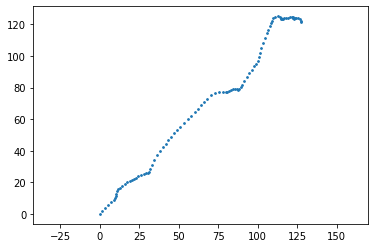

In [11]:
test_words = "ACDC"
test_batch = {"c": torch.tensor([alpha_to_num[c] for c in test_words]).unsqueeze(0).to(DEVICE), "c_len": torch.tensor([len(test_words)]).to(DEVICE)}


# torch.save(model.state_dict(), model_state_dict_path)
out = predict_no_guidance(model, test_batch)
# img_path = os.path.join(MODELS_DIR, "test_img_epoch-{}.jpg".format(epoch))
draw(out, None)

In [12]:
model_dir = MODELS_DIR
print(model_dir)
model = torch.load(os.path.join(model_dir, "model.pth"))
model.load_state_dict(torch.load(os.path.join(model_dir, "model_state_dict.pth")))

saved_models/Convolution-HWFT


<All keys matched successfully>

In [13]:
predict_no_guidance(model({"c": batch['c'][0], "c_len": batch['c_len'][0]}))

KeyError: 'x'